# First Post: Getting Started with Deep Learning and FastAI Lesson 2

### 04/28/2023

## Intro 

This blog will document my progress as I explore how to apply deep learning to practical problems. It seems more likely that these models will touch every aspect of people’s lives within a decade, and I see having a basic understanding of how they work as critical in keeping up with future technology. 

Initially, I will cover notes from the course Practical Deep Learning for Coders https://course.fast.ai/ and the textbook Deep Learning for Coders with Fastai and PyTorch https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527. 

Blogs will be written in Jupyter Notebooks and exported to HTML so that I can run and verify all the code I am working on before publishing. 

## The First Project

This first model that I am building will be very similar to the “Bear Classifier” used in textbook chapter 2. Instead of identifying types of bears, I will identify car models instead. This should produce the world’s first Type of Guy™ classifier for Subaru drivers as you can obviously tell exactly what a person is like from their car. 


### Setup

In [1]:
!pip install -Uqq fastbook

This is a line that Jeremy (https://twitter.com/jeremyphoward) recommends putting at the top of each notebook to make sure we have the latest library. -U means to upgrade and qq means quiet: display only the messages with ERROR,CRITICAL log levels. It’s for upgrading a package and not polluting your output with a lot of text. 

In [2]:
!pip install -qq nbdev

nbdev is used in this notebook to take a look at fastai documentation. From their github:
>nbdev is a notebook-driven development platform. Simply write notebooks with lightweight markup and get high-quality documentation, tests, continuous integration, and packaging for free! https://github.com/fastai/nbdev

Similar to the fastbook install, I used qq to keep the output logs from filling up this notebook. 

In [3]:
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

Import the tools we will need from the fastai library. 

One topic the textbook goes into that Jeremy moves away from is using bing image search. In the course videos he mentions that creating the API key in Azure is more trouble than it is worth so you should just use DuckDuckGo, but I went through all that hassle before watching the video! (oops) So I'll use the key I generated and pull images from Bing. I will probably delete this right before publishing anywhere publicly, FYI. 

Important takeaway: watch the fastai video lessons before developing anything as the latest recommendations can be really useful. 

In [4]:
key = os.environ.get('Azure Search Key', 'XXX' )

This defines my Azure search API key. You will need to replace this with your own key if you want to follow along. 

In [5]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

You can just type any function as an input into a notebook and the output will tell you where it is defined and what the arguments are. 

### Using the Search API

In [6]:
results = search_images_bing(key, 'subaru outback')
ims = results.attrgot('contentUrl')
len(ims)

150

This code is taken from the book but modified to get 150 pictures of Subaru outbacks instead of 150 pictures of grizzly bears. Len(ims) just gives us the length of the ims "L".

I don't really know what attrgot means, but a really cool thing about the fastai library and these notebooks is that I can just doc function call: 

In [7]:
doc(results.attrgot)

The "show in docs" links to https://fastcore.fast.ai/foundation.html#l.attrgot where you can then follow links which explain what Ls are:

>L is a drop in replacement for a python list. Inspired by NumPy, L, supports advanced indexing and has additional methods (outlined below) that provide additional functionality and encourage simple expressive code. 

> Example when items are not a dict:

> a = [SimpleNamespace(a=3,b=4),SimpleNamespace(a=1,b=2)]    
> test_eq(L(a).attrgot('b'), [4,2])

> Example of when items are a dict:

> b =[{'id': 15, 'name': 'nbdev'}, {'id': 17, 'name': 'fastcore'}]    
> test_eq(L(b).attrgot('id'), [15, 17])



You can also type ?*func_name* and run it to open a window with the signature of the function and a short description. You can type ??*func_name* to get a window with the signature of the function, a short description, and the source code.  

In [8]:
?results.attrgot

Signature: results.attrgot(k, default=None)
Docstring: Create new `L` with attr `k` (or value `k` for dicts) of all `items`.
File:      /usr/local/lib/python3.9/dist-packages/fastcore/foundation.py
Type:      method


In [9]:
??results.attrgot

Signature: results.attrgot(k, default=None)
Docstring: Create new `L` with attr `k` (or value `k` for dicts) of all `items`.
Source:   
    def attrgot(self, k, default=None):
        return self.map(lambda o: o.get(k,default) if isinstance(o, dict) else nested_attr(o,k,default))
File:      /usr/local/lib/python3.9/dist-packages/fastcore/foundation.py
Type:      method


Next, we will take a look at one of the pictures in that image list (really an L).

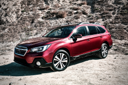

In [10]:
dest = 'images/subaru_outback.jpg'
download_url(ims[0],dest)

im = Image.open(dest)
im.to_thumb(128,128)

So, we defined a string that will be the location of our image. When I run the download_url function, it created an images directory and saved a single jpg with the name subaru_outback in that folder. We can see what the ims[0] argument we actually passed was: 

In [11]:
ims[0]

'https://st.automobilemag.com/uploads/sites/11/2018/03/2018-Subaru-Outback-2-5i-Limited-52.jpg'

So the argument we passed was just a URL (maybe that should have been obvious from the function name 😂). 

In [12]:
doc(download_url)

### Getting Images for Training

For each Subaru that I want my model to be able to recognize, I will have a string that is a stereotype of the person who drives that car. It may be hard to keep track of all the stereotypes that I am using though, so for debugging, I will just use the actual car models as the data labels and then use a case statement or something at the end to provide the *predictions*. This will also let me easily upgrade things later if I think of more clever jokes for this bit.  

In [13]:
subaru_cars = 'forester' , 'outback', 'wrx', 'brz', 'ascent', 'crosstrek'

I am going to have one folder with pictures of non-Subaru vehicles so we can rule those out of predictions when we go to do inference. Also, for fun, I will include the 412EPX as suggested by my friend RandomSprint on an earlier model. I’ll try to include some other helicopters in the not Subaru set so it can tell those apart.If this goal is too ambitious, I’ll just cut the helicopters later. 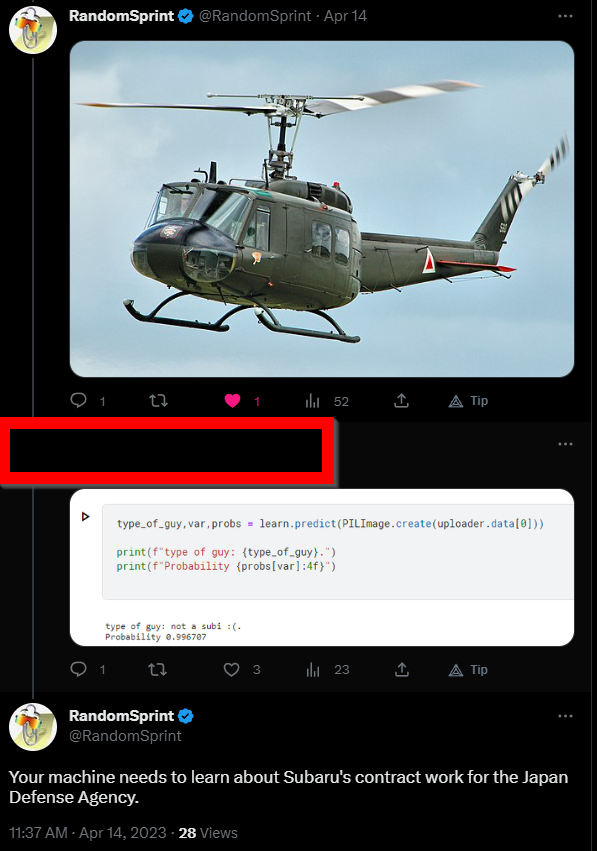


In [14]:
path = Path('models')

if not path.exists():
    path.mkdir()
    
    for cars in subaru_cars:
        dest = (path/cars)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'subaru {cars} exterior photo')
        download_images(dest, urls = results.attrgot('contentUrl'))
        results = search_images_bing(key, f'old subaru {cars} exterior photo')
        download_images(dest, urls = results.attrgot('contentUrl'))
       
        
    dest = (path/'not')
    dest.mkdir(exist_ok=true)
    results = search_images_bing(key, 'car exterior photo -subaru')
    download_images(dest, urls = results.attrgot('contentUrl'))
    results = search_images_bing(key, 'old car exterior photo -subaru')
    download_images(dest, urls = results.attrgot('contentUrl'))
    results = search_images_bing(key, 'helicopter photo -412EPX')
    download_images(dest, urls = results.attrgot('contentUrl'))

    
    dest = (path/'EPX')
    dest.mkdir(exist_ok=true)
    results = search_images_bing(key, '412epx exterior photo')
    download_images(dest, urls = results.attrgot('contentUrl')) 
    

With this code, I will only download new images if the "models" folder does not exist. Once that has been made, the notebook will just jump over that section and not download new files. I have folders for each model, and I included a search for "old" as well to make sure I get different types and not just the newest models. My not folder includes cars and helicopters that are not Subarus, and my EPX folder should only contain pictures of that specific heli. 

In [15]:
fns = get_image_files(path)
fns

(#2151) [Path('models/EPX/34f1e393-a85d-435a-97cb-52d3b909e8e4.jpg'),Path('models/EPX/96181253-a435-49cf-b3cd-cb248651b1eb.jpg'),Path('models/EPX/b628ff16-ba5e-4006-adb5-8a769243544f.jpg'),Path('models/EPX/c0442f98-552a-48d7-b4b4-379eea5f3677.jpg'),Path('models/EPX/33e0c473-cd02-4005-8c46-01f3ac808cc5.jpg'),Path('models/EPX/f22e8348-841c-46c9-952b-dcc5fb79de79.jpg'),Path('models/EPX/bdbe14d6-9c2f-4d94-9793-ffe0ef981128.jpg'),Path('models/EPX/084a7aa8-dc4b-4480-a186-0f474105edb5.jpg'),Path('models/EPX/f50b6d3a-ca1e-439a-b75e-627fd20ed6a1.jpg'),Path('models/EPX/ce592225-03fd-422b-ae55-41e584f93ac6.jpg')...]

In [16]:
doc(get_image_files)

In [17]:
failed = verify_images(fns)
failed

(#0) []

 This will get us any images that are corrupted so that they can be removed from our set below:

In [18]:
failed.map(Path.unlink)

(#0) []

I kept getting error messages when running fine tune, so I added this code to fix the warning
> UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images 

In [19]:
all_folder_names = 'forester' , 'outback', 'wrx', 'brz', 'ascent', 'crosstrek', 'not', 'EPX'

for o in all_folder_names:
    # convert all PNG, GIF images to RGBA
    for image in os.listdir(path/o):
        ext = os.path.splitext(image)[1]
        
        if ext in ['.png', '.gif']:
            new_filename = os.path.splitext(image)[0]+'.png'
            img = Image.open(path/o/image)
            img = img.convert('RGBA')
            img.save(path/o/new_filename)
            print('saving: ' + new_filename)

saving: 96708cbf-7195-4d14-8b4c-1118333b6d0c.png
saving: d2cdd69c-7101-4154-87df-33cdfaac45ad.png
saving: 3331a1d3-37c5-4a8d-9ead-2d2101c3e2d6.png
saving: 19f3514d-ece1-4d3d-b278-8553ca04f577.png
saving: 509b6fe3-673d-42f4-8d8c-efab61296fc9.png
saving: df779c44-3e77-4d73-920c-4e527c2e64e0.png
saving: 511c2baa-19bf-414d-9b92-7a96996697cc.png
saving: 1eb2ec4a-4d72-4706-b9b5-f0dd086586e1.png
saving: 0940885d-f3b8-4828-a5bb-ee5e6d7859b9.png
saving: 6afc5f59-0203-442b-823b-8b22615c9c06.png
saving: 7596d269-90cd-431f-952c-3686ce0ce012.png
saving: d72b1ab3-b81f-4459-aa20-d5e31619d33c.png
saving: b609d85a-13c8-49df-89d0-5c0e56c28555.png
saving: 3f0cefb5-0168-4038-a533-835ca7fd5549.png
saving: d8529c66-2ce8-49a9-a288-56830a79f02a.png
saving: e77c1ed6-233b-480a-935c-8e717d027cc0.png
saving: e0a2ba05-f13d-4b8d-b07b-24ae75b6091c.png
saving: 0e0d8694-5223-4366-b5f9-c0b91ba40f1d.png
saving: 8274a4f7-1bb2-4b81-82d4-0adc2f7450df.png
saving: 0c5db029-15ca-4d16-aaf7-6b3ef28e8e80.png
saving: 981be5c5-da3

In [20]:
doc(img.save)

### Creating the DataBlock

Next, we turn our downloaded data into a DataLoaders object. The book describes DataLoaders

>A thin class that just stores whatever DataLoader objects you pass to it and makes them available as train and valid. 

and the book pg 222 describes DataLoader

>An iterator that provides a stream of mini-batches, where each mini-batch is a tuple of a batch of independent variables and a batch of dependent variables. 

In [21]:
doc(DataLoader)

To create a DataLoaders object from our data we will need to tell fastai at least four things:
1. The kinds of data we have
2. How to get a list of items
3. How to label items
4. How to make the validation set

Here is the code:

In [22]:
vehicles = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = Resize(128))

First, we pass blocks as a tuple that specifies the *types* we want for the independent and dependent variables.
>blocks = (ImageBlock, CategoryBlock)   

The items that our DataLoaders will be using will be file paths. In order to get them, we use the get_image_files function which takes a path and returns a list of all the images in the path. 

>get_items = get_image_files

Next, we tell fastai what function to use to split our data into a training set and a validation set. Because the seed is a static number, we will get the same list for our training set and validation set unless the seed is changed. We are just splitting the set randomly, but other splits could be advantageous depending on what kind of data you are working with. The % of data we reserve for our training set is 20 which is the same as the default for this function. 

>splitter = RandomSplitter(valid_pct=0.2, seed=42)

Y variables are dependent and X variables are independent. get_y is used to assign the labels of our dataset. Parent_label is a fastai function used to get the name of the folder that a file is in. All of our folder names will be Subaru models: 'forester' , 'outback', 'wrx', 'brz', 'ascent', 'crosstrek', and also ‘not’ and ‘EPX’. 

>get_y = parent_label

The last argument to the DataBlock function is an *item transform* - ie a piece of code that runs on each individual item. Because we feed the model multiple images at the same time, we want them to all be the same size. Resize(128) will change each item into a photo with a size of  pixels. 

> item_tfms = Resize(128)

In [23]:
dls = vehicles.dataloaders(path)

Vehicles is a DataBlock object which is like a **template** for creating a DataLoaders. We then tell fastai the actual source of our data, which in this case is the path where the images can be found. 


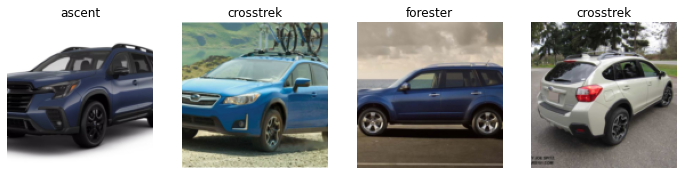

In [24]:
dls.valid.show_batch(max_n=4, nrows=1)

A DataLoader is a class that provides batches of a few items at a time to the GPU. When you loop through a DataLoader. Fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. The show_batch method can let us look at a few of them.

Resize just crops the image so we could lose some information. Another option is to pad the images (fill empty space with black) or squish/stretch the image. You can change the DataBlock & the DataLoaders by using the new method:


In [25]:
doc(vehicles.new)

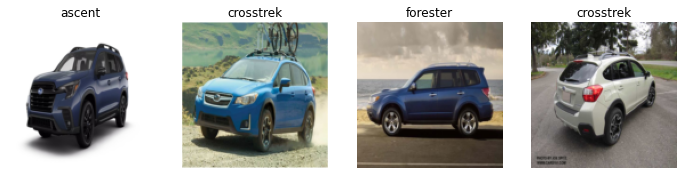

In [26]:
vehicles = vehicles.new(item_tfms = Resize(128, ResizeMethod.Squish))
dls = vehicles.dataloaders(path)
dls.valid.show_batch(max_n=4,nrows=1)

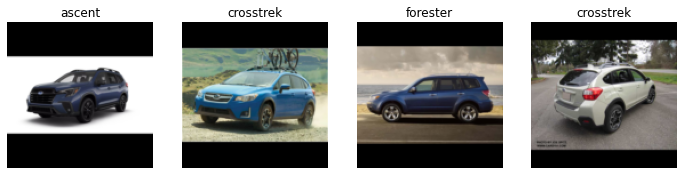

In [27]:
vehicles = vehicles.new(item_tfms = Resize(128, ResizeMethod.Pad,pad_mode='zeros'))
dls = vehicles.dataloaders(path)
dls.valid.show_batch(max_n=4,nrows=1)

There are some obvious disadvantages to all these options: crop, squish, and pad: Crop removes features which could be helpful for recognition. Squish distorts pictures so they might not end up similar to our inference inputs. Pad leads to wasted compute, and lower effective resolution of the image we want to use. 


What is usually done is to randomly **select part of the image and just crop to that part. On each epoch (pass though all the images in the dataset), we randomly select a different part of each image**. This way, the model can learn to recognize different features in our images. 


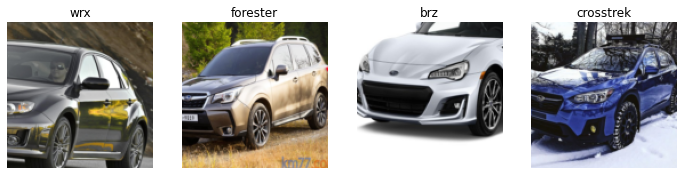

In [28]:
vehicles = vehicles.new(item_tfms = RandomResizedCrop(128, min_scale=0.3))
dls = vehicles.dataloaders(path)
dls.train.show_batch(max_n=4,nrows=1)

Note that we are now using the train method to look at the training images. You can run the same show_batch using unique=True to get different variations of the same image. 

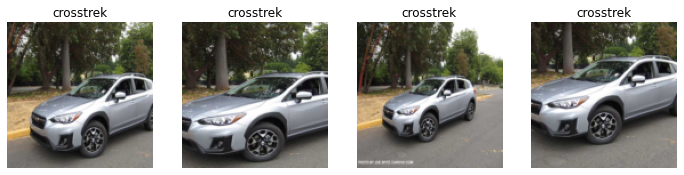

In [29]:
dls.train.show_batch(max_n=4,nrows=1,unique=True)

# Data Augmentation

Because the images are now all the same size, we can do a transformation on a batch using the batch_tfms parameter. This example will use double the amount of augmentation compared to default so you can clearly see the differences.

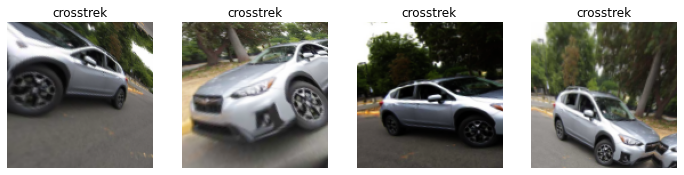

In [30]:
vehicles = vehicles.new(item_tfms = RandomResizedCrop(128, min_scale=0.3), batch_tfms = aug_transforms(mult=2))
dls = vehicles.dataloaders(path)
dls.train.show_batch(max_n=4,nrows=1, unique=True)

# Training the Model and Cleaning

In his video, Jeremy made the point that you should always train a model first before cleaning your data. This will help identify where you are getting problems. I’ll use RandomResizedCrop with at least 50% of images, resized to 224 pixels which is a fairly standard size for image classification. I will also use the default settings for aug_transforms. 

In [31]:
vehicles = vehicles.new(
    item_tfms= RandomResizedCrop(224, min_scale =0.5),
    batch_tfms = aug_transforms())
dls = vehicles.dataloaders(path)

Now we can create the learner and fine-tune:

In [33]:
learn = vision_learner(dls,resnet18, metrics=error_rate)

In [34]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.434352,1.199903,0.437209,00:24


epoch,train_loss,valid_loss,error_rate,time
0,1.473132,0.966183,0.339535,00:23
1,1.210066,0.798298,0.260465,00:23
2,0.960586,0.733572,0.232558,00:23
3,0.792463,0.716992,0.223256,00:24


We can see what mistakes the model is making using the confusion matrix: 

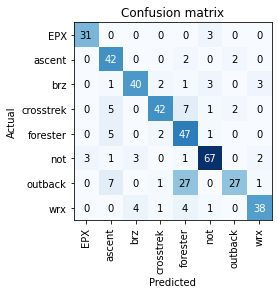

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Seems like it gets forester and outback confused. Outbacks, foresters, and ascents do have some similarity so it makes sense it would confuse them. Let’s take a look at top losses:

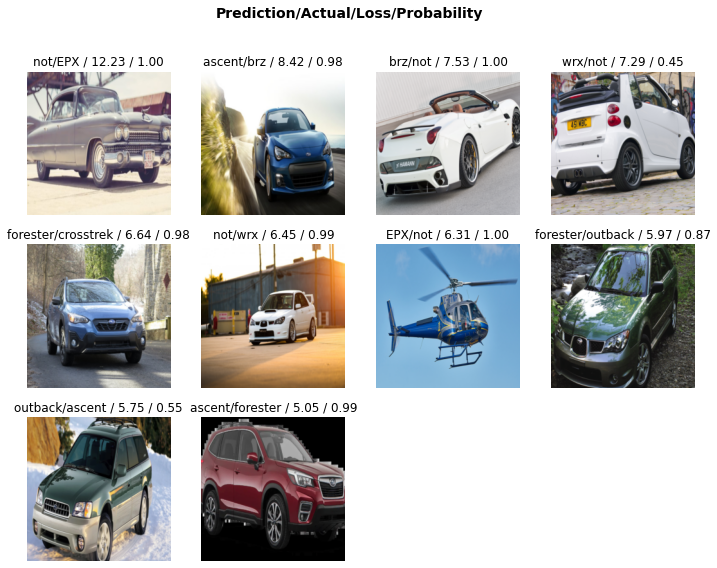

In [36]:
interp.plot_top_losses(10)

Can also change the text size: 

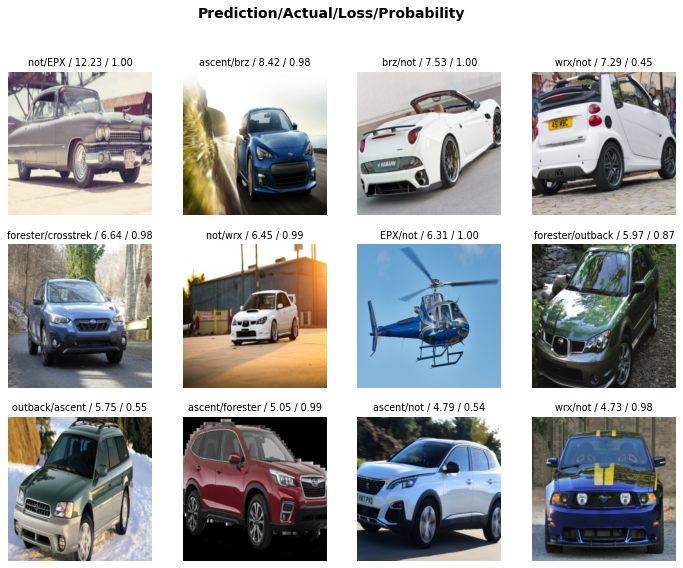

In [38]:
plt.rcParams.update({'font.size': 8})
interp.plot_top_losses(12)

Looks like we will need some clean up. I probably won’t be able to get everything perfect, but one good aspect of this project is that my outputs will be a type of guy and not a specific model so cars that looks the same have the same stereotypes. Also, the helicopter is just for fun so it doesn’t need to be super accurate. Maybe more training epochs will fix the confidence of that false positive EPX. 

Fastai has a helpful gui called ImageClassifierCleaner: 

In [39]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [40]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

I only deleted images out of the data. None seemed to be misclassified entirely. If they were I could also run

> for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]),path/cat) 

Now I will retrain with more epochs: 

In [41]:
vehicles = vehicles.new(
    item_tfms= RandomResizedCrop(224, min_scale =0.5),
    batch_tfms = aug_transforms())
dls = vehicles.dataloaders(path)

learn = vision_learner(dls,resnet18, metrics=error_rate)
learn.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,time
0,2.482075,1.352710,0.455814,00:24


epoch,train_loss,valid_loss,error_rate,time
0,1.397365,1.108999,0.379070,00:24
1,1.204567,0.933520,0.323256,00:24
2,1.037699,0.805295,0.288372,00:23
3,0.901599,0.629324,0.204651,00:23
4,0.756034,0.702498,0.211628,00:24
5,0.619578,0.671141,0.193023,00:23
6,0.526768,0.576281,0.193023,00:25
7,0.426766,0.539114,0.169767,00:24
8,0.343169,0.484222,0.146512,00:23
9,0.280580,0.475952,0.134884,00:23


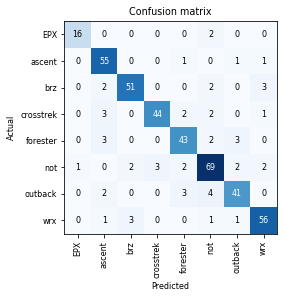

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

After retraining, it looks like there is still some significant error. The largest categories are confusing foresters and outbacks. Honestly, I’m OK with that. It still seems pretty good for a first project. Better to move on and I can revisit later when I know better methods if I like. 

In [43]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

Now, I can export the model and start working on an app. 

# Creating an App

At this time, the easiest way to create and deploy a functional application using my model is using gradio and hugging faces spaces. There is an option on the site to “create new space”. Jeremy recommended using the apache license because it makes it easy to share without worrying about patents. 
After hitting create, I cloned the repo using the git command provided by the site. I did this by creating a directory in the Ubuntu environment on my PC and using the git command in terminal:

>$git clone https://huggingface.co/spaces/tjeagle/Subaru

Next I created an app.py script file using nbdev in jupyter notebooks. The #| commands at the top of cells tell the function which code to export to app.py. The first line describes what the file should be called: I will put the text below as markdown as it represents the input code in another workbook. Each |#export is the start of a new cell, but it is only used for the code we want in the final app.py script.


> #|default_exp app

> path = Path('script')\
> import nbdev 

>#|export\
>from fastai.vision.all import *

>#|export\
>learn = load_learner('export.pkl')

><pre>
#|export
def type_of_guy(model):
    return{
        'ascent': 'soccer mom',
        'brz': 'soccer mom',
        'crosstrek': 'lists hiking as their hobby. never hikes',
        'EPX': 'Japanese defense force',
        'forester': 'coexist sticker',
        'not': 'not a subi :(',
        'outback': 'climbing gym',
        'wrx': 'monster energy'
        }.get(model, 'error')
</pre>

>#|export\
>labels = learn.dls.vocab\
>def predict(img):\
>    img = PILImage.create(img)\
>    pred,pred_idx,probs = learn.predict(img)\
>    return {type_of_guy(labels[i]): float(probs[i]) for i in range(len(labels))}

>#|export\
>examples = ['Bell_412.jpg','Ferrari.jpg','WRX.jpg','Crosstrek.jpg']

>#|export\
>import gradio as gr\
>gr.Interface(fn=predict, inputs=gr.inputs.Image(shape=(512, 512)), outputs=gr.outputs.Label(num_top_classes=1),examples=examples).launch()

>nbdev.export.nb_export('app.ipynb', path)\
>print('Export successful')
    

Next I had to add all of the necessary files to the directory that I cloned earlier. git add did not work for the pkl file so I ended up adding that file using github desktop instead. Then I committed and pushed the files and HF built my space using the code. 

* app.py
* requirements.txt
* export.pkl

Example images:
* Bell_412.jpg
* Crosstrek.jpg
* Ferrari.jpg
* WRX.jpg

requirements.txt allows us to install the packages for whatever environment we need. My file looks like this:
> fastai\
scikit-image\
gradio\
git+https://github.com/huggingface/huggingface_hub

The final app was built and is fully functional at this link: https://huggingface.co/spaces/tjeagle/Subaru

Another neat thing is that I can retrain the model any time using a different pretained model or with better cleaning or methods and just push that pkl file to improve the app.


Initially I had used a match statement to make my type of guy function, but this feature was only implemented in python 3.10. I had to change it to the dictionary instead because I saw in the build logs for the HF space that it was using python 3.8. 


Next I wanted to create a website that called the model using the hugging faces API, but it seems that the method that Jeremy used in the video no longer works. It might be the case that you need to pay for API endpoints now. If I can figure it out, I will return to using HF API later, but I will move on to lesson 3. 

# Chapter 2 Textbook Questions and Answers

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.

>Tommy: We could get images of bears in low-light conditions or we could get poor quality or only partial photos. 

>Book: There are many cases that the bear classification model could fail, especially if these cases were not represented in the training data:
>* The bear is partially obstructed
> * Nighttime images are passed into the model
> * Low-resolution images are passed into the model
> * The bear is far away from the camera
> * The bear training dataset is highly biased towards one type of features (eg. color)

2. Where do text models currently have a major deficiency?

> T: Accuracy, whether the text model is actually producing facts or just hallucinating. 

> B: Text models can generate context-appropriate text (like replies or imitating author style). However, text models still struggle with correct responses. Given factual information (such as a knowledge base), it is still hard to generate responses that utilizes this information to generate factually correct responses, though the text can seem very compelling. This can be very dangerous, as the layman may not be able to evaluate the factual accuracy of the generated text.

3. What are possible negative societal implications of text generation models?

> T: Spam, misinformation, impersonation, “pollution” i.e., we could end up with a very large amount of low-quality text data that is hard to separate out from verifiable information. 

>B: The ability for text generation models to generate context-aware, highly compelling responses can be used at a massive scale to spread disinformation (“fake news”) and encourage conflict.

4. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?

> T: Implement in parallel with humans first.

> B: The predictions of the model could be reviewed by human experts for them to evaluate the results and determine what is the best next step. This is especially true for applying machine learning for medical diagnoses. For example, a machine learning model for identifying strokes in CT scans can alert high priority cases for expedited review, while other cases are still sent to radiologists for review. Or other models can also augment the medical professional’s abilities, reducing risk but still improving efficiency of the workflow. For example, deep learning models can provide useful measurements for radiologists or pathologists.

5. What kind of tabular data is deep learning particularly good at?

> T: “high cardinality” data, that is a very large set of discrete choices like zip codes. 

> B: Deep learning is good at analyzing tabular data that includes natural language, or high cardinality categorical columns (containing larger number of discrete choices like zip code).

6. What's a key downside of directly using a deep learning model for recommendation systems?

> T: It may focus too much on past behavior and not predicting what is needed for the future. 

> B: Machine learning approaches for recommendation systems will often only tell what products a user might like, and may not be recommendations that would be helpful to the user. For example, if a user is familiar with other books from the same author, it isn’t helpful to recommend those products even though the user bought the author’s book. Or, recommending products a user may have already purchased.

7. What are the steps of the Drivetrain Approach?

> T: Four steps:
> 1. Consider objectives
> 2. Determine what inputs you can control
> 3. Determine what data you can get
> 4. Build a model to best meet objectives

>B: 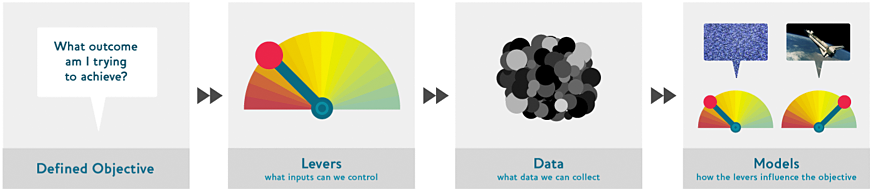

8. How do the steps of the Drivetrain Approach map to a recommendation system?

> T:
> 1. Objective = drive sales
> 2. Lever = ranking of recommendations 
> 3. Experiments and A/B tests
> 4. Build models and choose the best one

> B: The objective of a recommendation engine is to drive additional sales by surprising and delighting the customer with recommendations of items they would not have purchased without the recommendation. The lever is the ranking of the recommendations. New data must be collected to generate recommendations that will cause new sales . This will require conducting many randomized experiments in order to collect data about a wide range of recommendations for a wide range of customers. This is a step that few organizations take; but without it, you don’t have the information you need to actually optimize recommendations based on your true objective (more sales!)

9. Create an image recognition model using data you curate, and deploy it on the web.

> T: Subaru detector to be posted. 

10. What is DataLoaders?

> T: DataLoaders is an object that acts like a template. It describes the info to be used to build a model. 

> B: The DataLoaders class is the **class** that passes the data to the fastai model. It is essentially a class that stores the required Dataloader objects (usually for train and validation sets).

11. What four things do we need to tell fastai to create DataLoaders?

> T: four things:
> 1. The data types
> 2. How to get the list of items
> 3. How to label the data 
> 4. How to create a validation set 

> B: 
> * what kinds of data we are working with
> * how to get the list of items
> * how to label these items
> * how to create the validation set

12. What does the splitter parameter to DataBlock do?

> T: Splitter creates a training and validation set. 

> B: In fastai DataBlock, you provide the splitter argument a way for fastai to split up the dataset into subsets (usually train and validation set). For example, to randomly split the data, you can use fastai’s predefined RandomSplitter class, providing it with the proportion of the data used for validation.

13. How do we ensure a random split always gives the same validation set?

> T: Pass the same seed as an argument. 

> B: It turns out it is impossible for our computers to generate truly random numbers. Instead, they use a process known as a pseudo-random generator. However, this process can be controlled using a random seed. By setting a random seed value, the pseudo-random generator will generate the “random” numbers in a fixed manner and it will be the same for every run. Using a random seed, we can generate a random split that gives the same validation set always.

14. What letters are often used to signify the independent and dependent variables?

> T: X = independent and Y = dependent.

> B: x is independent. y is dependent.

15. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?

> T: Crop cuts out some data, pad fills in space with black, squish distorts the image to fit in specified dimensions. Choice depends on how important it is to process all of the data and whether distortion will change how well an image can be recognized. 

> B: default resized (cropped) grizzly image:

>!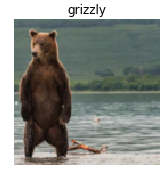

>crop is the default Resize() method, and it crops the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. For instance, if we were trying to recognize the breed of dog or cat, we may end up cropping out a key part of the body or the face necessary to distinguish between similar breeds.

>pad is an alternative Resize() method, which pads the matrix of the image’s pixels with zeros (which shows as black when viewing the images). If we pad the images then we have a whole lot of empty space, which is just wasted computation for our model, and results in a lower effective resolution for the part of the image we actually use.

>padded grizzly image:

>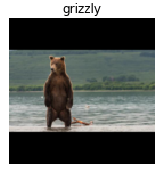

>Screen Shot 2020-03-25 at 11.25.41 AM

>squish is another alternative Resize() method, which can either squish or stretch the image. This can cause the image to take on an unrealistic shape, leading to a model that learns that things look different to how they actually are, which we would expect to result in lower accuracy.

>grizzly image squished:

>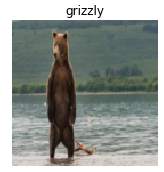

>Screen Shot 2020-03-25 at 11.29.00 AM

>Which resizing method to use therefore depends on the underlying problem and dataset. For example, if the features in the dataset images take up the whole image and cropping may result in loss of information, squishing or padding may be more useful.

>Another better method is RandomResizedCrop, in which we crop on a randomly selected region of the image. So every epoch, the model will see a different part of the image and will learn accordingly.

16. What is data augmentation? Why is it needed?

> T: Data augmentation changes the data used as inputs for training to make it more useful for a range of inference inputs without actually getting new data. 

> B: Data augmentation refers to creating random variations of our input data, such that they appear different, but not so different that it changes the meaning of the data. Examples include flipping, rotation, perspective warping, brightness changes, etc. Data augmentation is useful for the model to better understand the basic concept of what an object is and how the objects of interest are represented in images. Therefore, data augmentation allows machine learning models to generalize . This is especially important when it can be slow and expensive to label data.

17. What is the difference between item_tfms and batch_tfms?

> T: Item describes transformation done individually to each item. Batch does the transformations in parallel to all the items in a batch (I assume you would want all images to be the same size, for example, before doing a batch transform.)

> B: item_tfms are transformations applied to a single data sample x on the CPU. Resize() is a common transform because the mini-batch of input images to a cnn must have the same dimensions. Assuming the images are RGB with 3 channels, then Resize() as item_tfms will make sure the images have the same width and height.
batch_tfms are applied to batched data samples (aka individual samples that have been collated into a mini-batch) on the GPU. They are faster and more efficient than item_tfms. A good example of these are the ones provided by aug_transforms(). Inside are several batch-level augmentations that help many models.

18. What is a confusion matrix?

> T: A grid showing the accuracy of our model on a validation set. 

> B: A class confusion matrix is a representation of the predictions made vs the correct labels. The rows of the matrix represent the actual labels while the columns represent the predictions. Therefore, the number of images in the diagonal elements represent the number of correctly classified images, while the off-diagonal elements are incorrectly classified images. Class confusion matrices provide useful information about how well the model is doing and which classes the model might be confusing .

19. What does export save?

> T: The model (weights). 

> B: export saves both the **architecture**, as well as the **trained parameters** of the neural network architecture. It also saves how the DataLoaders are defined.

20. What is it called when we use a model for getting predictions, instead of training?

> T: Inference

> B: Inference

21. What are IPython widgets?

> T: Handy little built-in UI tools. 

> B: IPython widgets are JavaScript and Python combined functionalities that let us build and interact with GUI components directly in a Jupyter notebook. An example of this would be an upload button, which can be created with the Python function widgets.FileUpload().

22. When might you want to use CPU for deployment? When might GPU be better?

> T: Would probably want to use a CPU when cost is a major constraint as it would be cheaper. You could use a GPU for things that need to be processed in parallel very quickly. 

> B: GPUs are best for doing identical work in parallel. If you will be analyzing single pieces of data at a time (like a single image or single sentence), then CPUs may be more cost effective instead, especially with more market competition for CPU servers versus GPU servers. GPUs could be used if you collect user responses into a batch at a time, and perform inference on the batch. This may require the user to wait for model predictions. Additionally, there are many other complexities when it comes to GPU inference, like memory management and queuing of the batches.

23. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?

> T: You have to build all of the infrastructure to communicate with the server and you would always need internet access to use it. 

> B: The application will require network connection, and there will be extra network latency time when submitting input and returning results. Additionally, sending private data to a network server can lead to security concerns.

>On the flip side deploying a model to a server makes it easier to iterate and roll out new versions of a model. This is because you as a developer have full control over the server environment and only need to do it once rather than having to make sure that all the endpoints (phones, PCs) upgrade their version individually.

24. What are three examples of problems that could occur when rolling out a bear warning system in practice?

> T: It could not work with low-quality images. It may suffer from connection issues to the server. It may be too slow to protect anybody. 

> B: The model we trained will likely perform poorly when:
> 1. Handling night-time images
> 2. Dealing with low-resolution images (ex: some smartphone images)
> 3. The model returns prediction too slowly to be useful

25. What is "out-of-domain data"?

> T: Data that is different than our training data but we still want to run our model on. 

> B: Data that is fundamentally different in some aspect compared to the model’s training data. For example, an object detector that was trained exclusively with outside daytime photos is given a photo taken at night.

26. What is "domain shift"?

> T: Where the type of data we see changes over time. 

> B: This is when the type of data changes gradually over time. For example, an insurance company is using a deep learning model as part of their pricing algorithm, but over time their customers will be different, with the original training data not being representative of current data, and the deep learning model being applied on effectively out-of-domain data.

27. What are the three steps in the deployment process?

> T:
> 1. Implement with direct human oversight
> 2. Limited scope implementation 
> 3. Full implementation 

> B:
>1. Manual process – the model is run in parallel and not directly driving any actions, with humans still checking the model outputs.

> 2. Limited scope deployment – The model’s scope is limited and carefully supervised. For example, doing a geographically and time-constrained trial of model deployment, that is carefully supervised.

> 3. Gradual expansion – The model scope is gradually increased, while good reporting systems are implemented in order to check for any significant changes to the actions taken compared to the manual process (i.e. the models should perform similarly to the humans, unless it is already anticipated to be better).
